
# CS211: Data Privacy
## In-Class Exercise, week of 11/14/2022

In [1]:
# Load the data and libraries
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')

def laplace_mech(v, sensitivity, epsilon):
    return v + np.random.laplace(loc=0, scale=sensitivity / epsilon)

def gaussian_mech(v, sensitivity, epsilon, delta):
    return v + np.random.normal(loc=0, scale=sensitivity * np.sqrt(2*np.log(1.25/delta)) / epsilon)

def gaussian_mech_vec(vec, sensitivity, epsilon, delta):
    return [v + np.random.normal(loc=0, scale=sensitivity * np.sqrt(2*np.log(1.25/delta)) / epsilon)
            for v in vec]
def gaussian_mech_RDP(val, sensitivity, alpha, epsilon):
    sigma = np.sqrt((sensitivity**2 * alpha) / (2 * epsilon))
    return val + np.random.normal(loc=0, scale=sigma)
def gaussian_mech_zCDP(val, sensitivity, rho):
    sigma_sq=sensitivity**2/(2*rho)
    sigma=np.sqrt(sigma_sq)
    return val+np.random.normal(loc=0,scale=sigma)

def pct_error(orig, priv):
    return np.abs(orig - priv)/orig * 100.0

song = pd.read_csv('https://raw.githubusercontent.com/DrewJep/cs211-final/main/TikTok_songs_2022.csv')


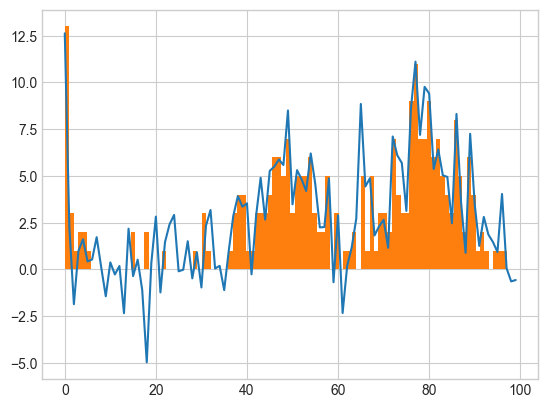

In [2]:
#Track popularity is on a range from 0 to 100
def track_pop_hist(epsilon):
    results = [len(song[song['track_pop']==pop]) for pop in range(0,100)]
    noisy_hist=[laplace_mech(r,1,epsilon) for r in results]
    return noisy_hist

plt.plot(track_pop_hist(1.0));
plt.hist(song['track_pop'], bins=100);

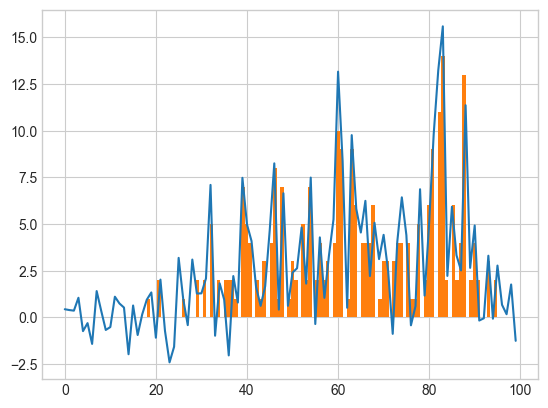

In [3]:
#popularity is on a scale from 0 to 100
def artist_pop_hist(epsilon):
    results = [len(song[song['artist_pop']==num]) for num in range(0,100)]
    noisy_hist=[laplace_mech(r,1,epsilon) for r in results]
    return noisy_hist

plt.plot(artist_pop_hist(1.0));
plt.hist(song['artist_pop'], bins=100);

In [ ]:
def range_query_synth(syn_rep, a, b):
    total = 0
    for i in range(a, b):
        total += syn_rep[i]
    return total

def track_pop_between_60_95_syn(epsilon):
    syn_rep=track_pop_hist(epsilon)
    return range_query_synth(syn_rep,60,95)
for i in range(1,6):  
    print("run:",i)  
    print('Synthetic answer:', track_pop_between_60_95_syn(1.0))
    print('True answer:', len(song[(song['track_pop'] >= 60) & (song['track_pop'] < 95)]))

run: 1
Synthetic answer: 128.80139113986036
True answer: 141
run: 2
Synthetic answer: 148.52789698913406
True answer: 141
run: 3
Synthetic answer: 135.99705409461555
True answer: 141
run: 4
Synthetic answer: 132.2816186631167
True answer: 141
run: 5
Synthetic answer: 137.99149515285634
True answer: 141


# Creating Marginals of the Aspects of Songs
- Danceability: how suitable a track is for dancing based on a combination of musical elements 
- Energy: a measure from 0.0 to 1.0 and represents a perceptual measure of intensity and activity
- Loudness: overall loudness of a track in decibels (dB)
- Mode: indicates the modality (major or minor) of a track, the type of scale from which its melodic content is
- Key: The key the track is in. Integers map to pitches using standard Pitch Class notation. E.g. 0 = C, 1 = C♯/D♭, 2 = D, and so

In [ ]:
def dp_marginal(col, epsilon):
    hist = song[col].value_counts()
    dp_hist = hist.apply(lambda x: laplace_mech(x, 1, epsilon))
    clipped = dp_hist.clip(lower=0)
    marginal = clipped / clipped.sum()
    return marginal


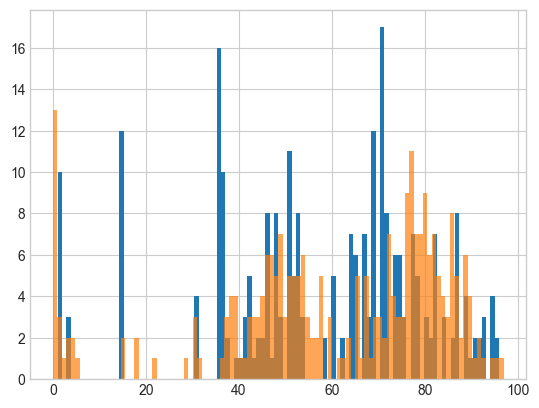

In [ ]:
def dp_synthetic_data(cols, n, epsilon):
    marginals = [dp_marginal(col, epsilon/len(cols)) for col in cols]
    syn_cols = [np.random.choice(m.index, n, p=m) for m in marginals]
    syn_data = pd.DataFrame({c : v for c, v in zip(cols, syn_cols)})
    return syn_data

syn_data = pd.DataFrame(dp_synthetic_data(['track_pop','danceability', 'energy', 'loudness', 'mode', 'key'], 258, 1.0))
syn_data
syn_data['track_pop'].hist(bins=100)
song['track_pop'].hist(alpha=0.7, bins = 100);

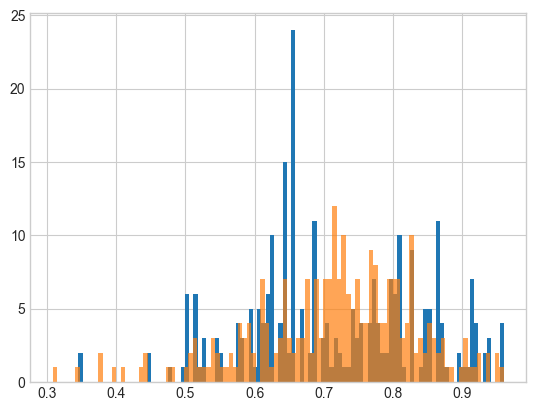

In [ ]:
syn_data['danceability'].hist(bins=100)
song['danceability'].hist(alpha=0.7, bins = 100);

## Accuracy of Synthetic Representation Test

In [ ]:
epsilon = 1.0
delta=1e-5
alpha = 5
rho = 0.00001
syn_rep=track_pop_hist(epsilon)
list=['track_pop','danceability', 'energy', 'loudness', 'mode', 'key']
print("Test Question: How many tracks have a track_pop between 60 and 95?")
true_answer = len(song[(song['track_pop'] >= 60) & (song['track_pop'] < 95)])
print('Percent error, synthetic representation:', 
      pct_error(true_answer, range_query_synth(syn_rep, 60, 95)))
lap_answer = laplace_mech(true_answer, 1, epsilon)
print('Percent error, Laplace mechanism:', 
      pct_error(true_answer, lap_answer))
gau_answer=gaussian_mech(true_answer,1,epsilon,delta)
print('Percent error, Gaussian mechanism:', 
      pct_error(true_answer, gau_answer))
gau_RDP_answer=gaussian_mech_RDP(true_answer,1,alpha,epsilon)
print('Percent error, Gaussian RDP mechanism:', 
      pct_error(true_answer, gau_RDP_answer))
gau_zCDP_answer=gaussian_mech_zCDP(true_answer,1,rho)
print('Percent error, Gaussian zCDP mechanism:', 
      pct_error(true_answer, gau_zCDP_answer))

Test Question: How many tracks have a track_pop between 60 and 95?
Percent error, synthetic representation: 0.5533293241681556
Percent error, Laplace mechanism: 0.4748148059901286
Percent error, Gaussian mechanism: 1.4495158810596265
Percent error, Gaussian RDP mechanism: 0.9294642590708448
Percent error, Gaussian zCDP mechanism: 174.58502545539244
